# Домашнее задание

Data contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### 1. Реализовать персональный топ  - принимает на вход возраст и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 27) - 3 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Совстречаемость - 3 балла

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок.

### 4. Коллаборативная фильтрация - 3 балла

Коллаборативную фильтрацию реализовывать как на слайде 51 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл. Реализовать U2I и I2I рекомендации.

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации

Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)

Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

# Жесткий дедлайн 15 декабря 23:59

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.

In [1]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
# import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy.sparse import coo_array

import re

In [2]:
books = pd.read_csv("BX-Books.csv")

/var/folders/bp/17h6b6pd1s3fm5ppjqspzk_sfr4y0s/T/ipykernel_92149/2179646983.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("BX-Books.csv")


In [3]:
interactions = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [4]:
interactions = interactions[interactions["Book-Rating"] != 0]

In [5]:
interactions.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


In [6]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
# сколько раз книга была прочитана
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [8]:
# сколько книг прочитал пользователь
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [9]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num
0,276726,0155061224,5,1,1
1,276729,052165615X,3,1,2
2,276729,0521795028,6,1,2
3,276736,3257224281,8,4,1
4,86583,3257224281,6,4,18


In [10]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [11]:
users = pd.read_csv('BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [12]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [14]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [15]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228


In [16]:
from scipy.sparse import coo_matrix
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

### Ищем id нужных книг

In [ ]:
for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
    if "David Copperfield" in j:
        print("idx:", i, "\tBook Title:", j)

idx: 10174 	Book Title: David Copperfield (Wordsworth Classics)
idx: 1074 	Book Title: David Copperfield (Penguin Classics)


### 1 персональный топ

In [17]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228


In [18]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [19]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))
            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [20]:
from sklearn.preprocessing import KBinsDiscretizer

class Personal():
    def __init__(self, interactions, users):
        self.books_mapping = interactions.loc[~interactions.duplicated("product_id"), ["product_id", "Book-Title"]]
        self.books_mapping = self.books_mapping.set_index("product_id").to_dict()['Book-Title']
        interactions = pd.merge(interactions, users, on="User-ID")
        self.location_recs = interactions.groupby(["Location", "product_id"])["Book-Rating"].mean()
        self.desc = KBinsDiscretizer(n_bins=10, encode="ordinal")
        self.nan_encode = interactions["Age"].mean()
        interactions["Age"] = interactions["Age"].fillna(self.nan_encode)
        interactions.loc[:, "Age"] = self.desc.fit_transform(interactions[["Age"]].values)[:, 0]
        self.age_recs = interactions.groupby(["Age", "product_id"])["Book-Rating"].mean()
        self.general_recommenders = interactions.groupby("product_id")["Book-Rating"].mean().sort_values(ascending=False)

    def encode_age(self, age):
        if age is None:
            age = self.nan_encode
        return self.desc.transform(np.array([[age]]))[0, 0]

    def get_age_recs(self, age, top_n):
        initial_age = age
        age = self.encode_age(age)
        
        if age in self.age_recs.index.get_level_values(0):
            recs = self.age_recs.loc[age].sort_values(ascending=False)[:top_n]
            recs = recs.index
        else:
            recs = self.general_recommenders[:top_n]
            recs = recs.index

        print(f"Для возраста: {initial_age}, получены следующие рекомендации:")
        for rec in recs:
            print(self.books_mapping[rec])

    def get_loc_recs(self, loc, top_n):
        if loc in self.location_recs.index.get_level_values(0):
            recs = self.location_recs.loc[loc].sort_values(ascending=False)[:top_n]
            recs = recs.index
        else:
            recs = self.general_recommenders[:top_n]
            recs = recs.index

        print(f"Для локации: {loc}, получены следующие рекомендации:")
        for rec in recs:
            print(self.books_mapping[rec])

In [21]:
personal = Personal(interactions, users)

/Users/21087699/work/myenv/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [22]:
personal.get_age_recs(10, 10)

Для возраста: 10, получены следующие рекомендации:
The Forgetting Room: A Fiction (Byzantium Book)
Smith of Wootton Major and Farmer Giles of Ham
On a Pale Horse (Incarnations of Immortality, Bk. 1)
The White Dragon (Dragonriders of Pern Vol 3)
Kate Vaiden
LIFE, THE UNIVERSE AND EVERYTHING (Hitchhiker's Trilogy (Paperback))
Web of Dreams (Casteel)
Petals on the Wind (Dollanganger)
Fallen Hearts (Casteel)
LATE NIGHT WITH DAVID LETTERMAN BOOK OF TOP TEN LISTS


In [23]:
personal.get_age_recs(33, 10)

Для возраста: 33, получены следующие рекомендации:
How the Grinch Stole Christmas!
Swim With the Sharks: Without Being Eaten Alive : Outsell, Outmanage, Outmotivate, and Outnegotiate Your Competition
Ramona the Pest (Ramona Quimby (Paperback))
Briar Rose
The Onion Girl (Newford)
Between the Sheets (Harlequin Blaze, 90)
The Covenant (Abram's Daughters)
The Maze
The Sweetest Taboo (Harlequin Blaze, 68)
The Darkangel: The Darkangel Trilogy, Volume I


In [24]:
personal.get_age_recs(None, 10)

Для возраста: None, получены следующие рекомендации:
More Scary Stories To Tell In The Dark
Fugitive Pieces
The House at Pooh Corner
Winnie-The-Pooh
Guardian Angel
Adventures in a TV Nation
Les Fleurs Du Mal
Angels &amp; Demons
The Power of Myth (Illustrated Edition)
Thinner


In [25]:
personal.get_loc_recs("usa", 10)

Для локации: usa, получены следующие рекомендации:
Wizard and Glass (The Dark Tower, Book 4)
Charlie and the Chocolate Factory
Der Vater Eines Morders
Before I Say Goodbye
A Dog Year: Twelve Months, Four Dogs, and Me
More Than Complete Hitchhiker's Guide: Complete &amp; Unabridged
Irish Whiskey: A Nuala Anne McGrail Novel (Nuala Anne McGrail Novels (Paperback))
Shrub: The Short but Happy Political Life of George W. Bush
Captain's Verses (New Directions Paperbook)
Wolves of Willoughby Chase (Wolves Chronicles)


In [26]:
personal.get_loc_recs("nyc, new york, usa", 10)

Для локации: nyc, new york, usa, получены следующие рекомендации:
Cunt: A Declaration of Independence (Live Girls Series)
The Outsiders
Three Junes
Wish You Were Here
Random Family: Love, Drugs, Trouble, and Coming of Age in the Bronx
Dude, Where's My Country?
Stupid White Men ...and Other Sorry Excuses for the State of the Nation!
Harriet the Spy
The Eagle and the Rose : A Remarkable True Story
Riding the Bus with My Sister: A True Life Journey


### 2 на основе метода кластеризации

In [27]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228


0.6056820309830838


100%|██████████| 28/28 [01:26<00:00,  3.07s/it]


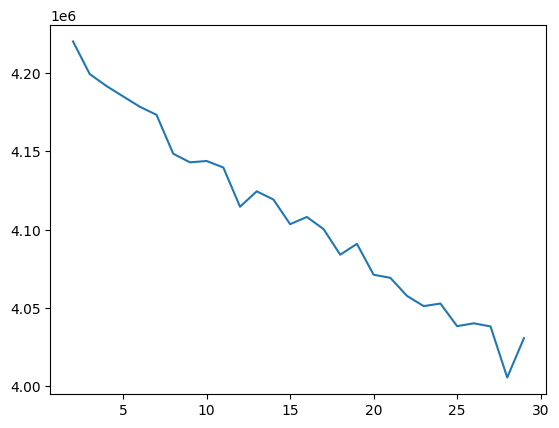

In [28]:
### Посчитаем количество кластеров


interactions_cluster = coo_array((interactions["Book-Rating"], (interactions.vid, interactions.product_id)))

decomp = TruncatedSVD(1000) 
interactions_cluster = decomp.fit_transform(interactions_cluster)
print(decomp.explained_variance_ratio_.sum())
res = []
for n_cluster in tqdm(range(2, 30)):
    algo = KMeans(n_clusters=n_cluster, n_init=10)
    algo.fit(interactions_cluster)
    res.append(algo.inertia_)

plt.plot(np.arange(2, 30), res)

In [ ]:
# можно сделать вывод, что данные довольно равномерны, во всяком случае для кластеризации
# KMeans. Тогда сделаем количество кластеров == 60

In [29]:
### Видим, что большинство кластеров, имеют правильные границы
### предсказания
decomp.inverse_transform(algo.cluster_centers_).max(axis=1)

array([ 5.10373527,  5.87130196, 10.48985935, 10.98589401, 10.43869724,
       10.86965552, 10.36626614,  9.61889637, 10.97379536, 10.78685602,
       10.38648944, 11.14311244, 10.65039035,  9.91898333, 10.30820228,
        6.97982112, 11.36177552,  8.55448337,  0.17352072,  3.48109194,
       10.32013587,  7.8078035 ,  7.67088302, 10.68842368, 11.02276398,
       10.97371165, 10.93657611, 11.07753698, 10.90446294])

In [30]:
decomp.inverse_transform(algo.cluster_centers_).min(axis=1)

array([-0.08197951, -0.01079233, -0.23512954, -0.46396775, -0.45970322,
       -0.54109002, -0.71427168, -0.67708233, -0.73535104, -0.41822227,
       -0.38705741, -0.54495503, -0.47181611, -0.4969533 , -0.60443398,
       -0.08374144, -0.64474836, -0.01819939, -0.0012838 , -0.07816658,
       -0.78528502, -0.03994791, -0.02236266, -0.28165455, -0.57524327,
       -0.54956953, -0.88749506, -0.62627904, -0.35315367])

In [32]:
class ClusterRecs:
    def __init__(self, interactions, users, n_clusters=70):
        self.books_mapping = interactions.loc[~interactions.duplicated("product_id"), ["product_id", "Book-Title"]]
        self.books_mapping = self.books_mapping.set_index("product_id").to_dict()['Book-Title']

        # можем так сделать, пушо закодировали OrdinalEncoder-ом, 
        interactions_cluster = coo_array((interactions["Book-Rating"], (interactions.vid, interactions.product_id)))
        self.decomp = TruncatedSVD(1000)
        interactions_cluster = self.decomp.fit_transform(interactions_cluster)
        self.algo = KMeans(n_clusters=n_clusters, n_init=10)
        self.algo.fit(interactions_cluster)
        means = self.decomp.inverse_transform(self.algo.cluster_centers_)
        self.recs = np.argsort(-means)

    def get_recs(self, books_read, top_n):
        user_encode = books_read
        # можем получить на вход - дикт {книга: рейтинг}
        if type(books_read) == dict:
            user_encode = np.zeros(len(self.books_mapping))
            for book, rating in books_read.items():
                user_encode[book] = rating

        cluster_idx = self.algo.predict(self.decomp.transform(user_encode[np.newaxis, :]))[0]
        recs = self.recs[cluster_idx][:top_n]
        print("Для пользователя с книгами : \n",
            ", ".join([
                self.books_mapping[book_idx] for book_idx in books_read.keys()
            ]),
            "\nполучены следующие рекомендации:"
        )
        for rec in recs:
            print(self.books_mapping[rec])

In [33]:
rec = ClusterRecs(interactions, users)

In [34]:
rec.get_recs({1: 10, 10: 1, 100: 3}, 10)

Для пользователя с книгами : 
 The Forgetting Room: A Fiction (Byzantium Book), 253, Merry Christmas, Amelia Bedelia (I Can Read Book 2) 
получены следующие рекомендации:
The Secret Life of Bees
Interview with the Vampire
Angels &amp; Demons
Where the Heart Is (Oprah's Book Club (Paperback))
Life of Pi
Wild Animus
A Painted House
To Kill a Mockingbird
Girl with a Pearl Earring
Jurassic Park


In [35]:
def get_user_books(vid):
    return interactions[interactions["vid"] == vid].set_index("product_id")["Book-Rating"].to_dict()

In [36]:
# есть совпадение!
rec.get_recs(get_user_books(2), 10)

Для пользователя с книгами : 
 Angels &amp; Demons, The Beach House, The Alibi, The Short Forever, Dead Aim, A Kiss Remembered 
получены следующие рекомендации:
The Secret Life of Bees
Interview with the Vampire
Angels &amp; Demons
Where the Heart Is (Oprah's Book Club (Paperback))
Life of Pi
Wild Animus
A Painted House
To Kill a Mockingbird
Girl with a Pearl Earring
Jurassic Park


In [37]:
# Ну фанатов гарри поттера видно из далека.
rec.get_recs(get_user_books(6), 10)

Для пользователя с книгами : 
 The Secret Life of Bees, Harry Potter and the Chamber of Secrets (Book 2), Making Minty Malone, Harry Potter and the Goblet of Fire (Book 4), Harry Potter and the Sorcerer's Stone (Book 1), She's Come Undone (Oprah's Book Club), Smoke and Mirrors: Short Fictions and Illusions, Harry Potter and the Prisoner of Azkaban (Book 3), The Bonesetter's Daughter, American Gods, Animal Farm, Harry Potter and the Chamber of Secrets (Book 2), The Hobbit: or There and Back Again, The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2), The Fellowship of the Ring (The Lord of the Rings, Part 1), Amazing Grace : Lives of Children and the Conscience of a Nation, The, The Golden Compass (His Dark Materials, Book 1), Harry Potter and the Prisoner of Azkaban (Book 3), The Dark Half, 1984, The Golden Compass (His Dark Materials, Book 1), Sandman: The Dream Hunters, American Gods: A Novel, Neverwhere, Something Wicked This Way Comes, The Adrian Mole Diaries : 

### Совстречаемость

In [47]:
interactions

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228
...,...,...,...,...,...,...,...,...,...
110514,27551,0849912970,10,6,6,http://images.amazon.com/images/P/0849912970.0...,Traveling Light: Releasing the Burdens You Wer...,9478,1035
110515,206652,1860465811,9,8,10,http://images.amazon.com/images/P/1860465811.0...,Wind-Up Bird Chronicle,10209,8112
110516,223525,1588720284,8,6,13,http://images.amazon.com/images/P/1588720284.0...,Why Your Life Sucks: And What You Can Do Abou...,10138,8754
110517,94153,0060652926,9,7,14,http://images.amazon.com/images/P/0060652926.0...,Mere Christianity,276,3740


In [70]:
from collections import defaultdict
from itertools import islice


class Coocurancy():
    def __init__(self, interactions):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.books_mapping = interactions.loc[~interactions.duplicated("product_id"), ["product_id", "Book-Title"]]
        self.books_mapping = self.books_mapping.set_index("product_id").to_dict()['Book-Title']

        # Для каждого пользователя собираем товары, с которыми он взамиодействовал
        cooc_df = interactions[["vid", "product_id", "Book-Rating"]].drop_duplicates().set_index("vid")
        cooc = defaultdict(lambda :defaultdict(lambda :0))
        cooc_size = defaultdict(lambda :defaultdict(lambda :0))

        for user in tqdm(cooc_df.index.unique()):
            books = cooc_df[cooc_df.index == user]
            for idx, (_, j) in enumerate(books[:-1].iterrows()):
                for _, k in books[idx+1:].iterrows():
                    val = (j["Book-Rating"] + k["Book-Rating"]) / 2
                    cooc[j["product_id"]][k["product_id"]] += val
                    cooc[k["product_id"]][j["product_id"]] += val
                    cooc_size[j["product_id"]][k["product_id"]] += 1
                    cooc_size[k["product_id"]][j["product_id"]] += 1

        # получим массивы и нормализуем их
        cooc = dict(cooc)
        for key_ in list(cooc.keys()):
            keys = []
            values = []
            for key, val in cooc[key_].items():
                keys.append(key)
                values.append(val / cooc_size[key_][key])
            
            keys = np.array(keys)
            values = np.array(values)
            vals_sort = np.argsort(-values)
            cooc[key_] = (keys[vals_sort], values[vals_sort])
        self.cooc = cooc
    
    def get_rec(self, i, top_n=10):
        print(f"Для книги : {self.books_mapping[i]}\n",
            "получены следующие рекомендации:"
        )
        for rec, dist in islice(zip(*self.cooc[i]), top_n):
            print(f"book: {self.books_mapping[rec]}, dist: {dist}")

In [85]:
cooc = Coocurancy(interactions)

100%|██████████| 10960/10960 [01:46<00:00, 102.59it/s] 


In [96]:
# получим продукт айди гаррипотера
harry_ids = interactions[interactions["Book-Title"].str.contains("Harry Potter")].product_id.unique()

hp_dist = []
for harry_book in harry_ids:
    for book, rating in zip(*cooc.cooc[harry_book]):
        if book in harry_ids:
            hp_dist.append(rating)

print(f"num_coocurances: {len(hp_dist)}")     
print(f"возможных пересечений книг о гарриоттере: {len(harry_ids) ** 2}")  
### Кто то из юзеров не прочитал всю серию...
print(f"средняя оценка взаимодействия HP: {sum(hp_dist) / len(hp_dist)}")       

num_coocurances: 188
возможных пересечений книг о гарриоттере: 625
средняя оценка взаимодействия HP: 9.415826682257673


In [97]:
cooc.get_rec(1)
# странно тут куча книг с гарри потером...

Для книги : The Forgetting Room: A Fiction (Byzantium Book)
 получены следующие рекомендации:
book: The Five People You Meet in Heaven, dist: 10.0
book: Harry Potter and the Prisoner of Azkaban (Book 3), dist: 10.0
book: Harry Potter and the Goblet of Fire (Book 4), dist: 10.0
book: Harry Potter and the Chamber of Secrets (Book 2), dist: 10.0
book: You Can Heal Your Life/101, dist: 10.0
book: Falling Angels, dist: 10.0
book: Darkness Visible: A Memoir of Madness, dist: 10.0
book: The Dark Is Rising, dist: 10.0
book: Sophie's World: A Novel About the History of Philosophy (Berkeley Signature Edition), dist: 10.0
book: The Grey King, dist: 10.0


In [98]:
cooc.get_rec(10)

Для книги : 253
 получены следующие рекомендации:
book: Memoirs of a Geisha Uk, dist: 9.5
book: Frankenstein: Or, the Modern Prometheus (World's Classics), dist: 9.5
book: River God, dist: 9.5
book: Good in Bed, dist: 9.0
book: Bite (Love Spell), dist: 9.0
book: Neverwhere : A Novel, dist: 9.0
book: Watership Down, dist: 8.5
book: Fast Food Nation: The Dark Side of the All-American Meal, dist: 8.5
book: Night Of Crash-Test Dummies, dist: 8.5
book: The Forgetting Room: A Fiction (Byzantium Book), dist: 8.5


In [122]:
cooc.get_rec(9732, 20)
# тут видно, что есть книги о гарри поттере в рекомендациях,
# но их заслоняют другие малочисленные выбросы с высокими оценками
# а HP изза массовости, получает высокие, но иногда и низкие оценки

Для книги : Ultimate Unofficial Guide to the Mysteries of Harry Potter
 получены следующие рекомендации:
book: The Fellowship of the Ring (The Lord of the Rings, Part 1), dist: 10.0
book: The Hobbit : The Enchanting Prelude to The Lord of the Rings, dist: 10.0
book: Harry Potter and the Chamber of Secrets (Book 2), dist: 10.0
book: Harry Potter and the Sorcerer's Stone (Book 1), dist: 10.0
book: The Bad Beginning (A Series of Unfortunate Events, Book 1), dist: 10.0
book: Artemis Fowl (Artemis Fowl, Book 1), dist: 10.0
book: The Vile Village (A Series of Unfortunate Events, Book 7), dist: 10.0
book: The Austere Academy (A Series of Unfortunate Events, Book 5), dist: 10.0
book: The Reptile Room (A Series of Unfortunate Events, Book 2), dist: 10.0
book: The Miserable Mill (A Series of Unfortunate Events, Book 4), dist: 10.0
book: The Ersatz Elevator (A Series of Unfortunate Events, Book 6), dist: 10.0
book: The Hostile Hospital (A Series of Unfortunate Events, Book 8), dist: 10.0
book: Th

### Коллаборативная фильтрация

In [ ]:
class Collaborative:
    ### я пытался перпеписать реализацию с демонстрации, но она буквально повторяла мои шаги
    ### поэтому я оставил как есть
    def __init__(self, interactions):
        self.csr_rates = coo_array((interactions["Book-Rating"], (interactions.vid, interactions.product_id)))
        self.books_mapping = interactions.loc[~interactions.duplicated("product_id"), ["product_id", "Book-Title"]]
        self.books_mapping = self.books_mapping.set_index("product_id").to_dict()['Book-Title']

    def user_based(self, idx):
        user_rates = self.csr_rates.getrow(idx).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        # считаем косинус между пользователем idx и всеми пользователями
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.copy(), metrics)
        # чтобы не рекомендовать уже просмотренные - зануляем веса просмотренных
        total_rate = (1 - user_rates.astype(bool)) * np.array(np.sum(rates, axis=0))[0]
        # печатаем рекомендации
        self.get_rec(watched_items, np.argsort(-total_rate)[:10],
                    np.sort(total_rate)[-10:])
        
    def item_based(self, idx):
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        # считаем косинус между товаром idx и всеми пользователями
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=1)).ravel()
        # печатаем рекомендации
        self.get_rec([idx], np.argsort(-total_rate)[:10],
                    np.sort(total_rate)[-10:])

    def get_rec(self, watched, recs, measure):
        print("Для пользователя с книгами : \n",
            ", ".join([
                self.books_mapping[book_idx] for book_idx in watched
            ]),
            "\nполучены следующие рекомендации:"
        )
        for rec, dist in zip(recs, measure):
            print(f"book: {self.books_mapping[rec]}, dist: {dist}")

In [ ]:
col = Collaborative(interactions)

In [ ]:
col.item_based(1)

Для пользователя с книгами : 
 The Forgetting Room: A Fiction (Byzantium Book) 
получены следующие рекомендации:
book: The Vampire Lestat (Vampire Chronicles, Book II), dist: 49.254263505885724
book: Jurassic Park, dist: 50.52880192274561
book: Bel Canto: A Novel, dist: 52.0722552721464
book: Midnight in the Garden of Good and Evil: A Savannah Story, dist: 52.61560129126597
book: The Secret Life of Bees, dist: 54.33297990433643
book: The Five People You Meet in Heaven, dist: 56.52037561782808
book: To Kill a Mockingbird, dist: 65.71666985558677
book: Like Water for Chocolate : A Novel in Monthly Installments with Recipes, Romances, and Home Remedies, dist: 77.81139449615745
book: The Venetian's Wife: A Strangely Sensual Tale of a Renaissance Explorer, a Computer, and a Metamorphosis, dist: 78.71431756233918
book: Lasher: Lives of the Mayfair Witches (Lives of the Mayfair Witches), dist: 87.95464337364761


In [ ]:
# С гарри поттерами - классика
col.item_based(4233)

Для пользователя с книгами : 
 Harry Potter and the Order of the Phoenix (Book 5) 
получены следующие рекомендации:
book: Harry Potter and the Order of the Phoenix (Book 5), dist: 181.71281629015226
book: Harry Potter and the Prisoner of Azkaban (Book 3), dist: 199.946950692618
book: Harry Potter and the Chamber of Secrets (Book 2), dist: 210.5961312601027
book: Harry Potter and the Goblet of Fire (Book 4), dist: 217.00168218636045
book: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), dist: 250.70730757859374
book: Harry Potter and the Sorcerer's Stone (Book 1), dist: 334.5355230835654
book: The Da Vinci Code, dist: 348.12377573090174
book: Harry Potter and the Goblet of Fire (Book 4), dist: 360.57686339789103
book: The Lovely Bones: A Novel, dist: 366.4004464079594
book: Harry Potter and the Chamber of Secrets (Book 2), dist: 1341.0000000000002


In [ ]:
col.user_based(6)
# тут нельзя увидеть гарри поттера в рекомендациях, так как этот 
# книжный наркоман уже все прочитал

Для пользователя с книгами : 
 Smoke and Mirrors: Short Fictions and Illusions, Amazing Grace : Lives of Children and the Conscience of a Nation, The, The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2), Complete Chronicles of Narnia, The Secret Life of Bees, Familiar Lullaby (Fear Familiar) (Harlequin Intrigue, No 614), The Golden Compass (His Dark Materials, Book 1), The Adrian Mole Diaries : The Secret Diary of Adrian Mole, Aged 13 3/4 : The Growing Pains of Adrian Mole, American Gods, Neverwhere, American Gods: A Novel, Stardust, The Bonesetter's Daughter, Harry Potter and the Chamber of Secrets (Book 2), Harry Potter and the Chamber of Secrets (Book 2), Harry Potter and the Prisoner of Azkaban (Book 3), Harry Potter and the Prisoner of Azkaban (Book 3), Harry Potter and the Goblet of Fire (Book 4), The Dark Half, The Duke, Making Minty Malone, 1984, Animal Farm, Something Wicked This Way Comes, Harry Potter and the Sorcerer's Stone (Book 1), The Hobbit: or The

In [ ]:
col.user_based(2)

Для пользователя с книгами : 
 The Alibi, The Beach House, A Kiss Remembered, The Short Forever, Dead Aim, Angels &amp; Demons 
получены следующие рекомендации:
book: Clara Callan, dist: 0.0
book: Step-Ball-Change, dist: 0.0
book: Eat Cake : A Novel, dist: 0.0
book: The Shelters of Stone (Earth's Children Series, No 5), dist: 0.0
book: The Clan of the Cave Bear, dist: 0.0
book: The Mammoth Hunters, dist: 0.0
book: Anatomy of the Spirit: The Seven Stages of Power and Healing, dist: 0.0
book: The Law of Love, dist: 0.0
book: Justice: Crimes, Trials, and Punishments, dist: 0.0
book: A Gracious Plenty : A Novel, dist: 0.0
